# 上海市房价预测

## 数据预处理

In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

# 1. 加载数据
file_path = "E:/作业/大三.下/Python数据分析项目实践/代码+数据集/house_data1.xlsx"
df = pd.read_excel(file_path, sheet_name="Sheet1")

# 2. 数据清洗
def clean_data(df):
    # 2.1 异常值处理
    df = df[(df["平米房价"] >= 5000) & (df["平米房价"] <= 100000)]
    
    # 2.2 重复值处理
    df = df.drop_duplicates(subset=["小区名", "房间大小", "房价(万元)"], keep="first")
    
    # 2.3 字段规范化
    # 提取修建年份的数值
    df["修建年份"] = df["修建年份"].str.extract(r'(\d{4})').astype(float)
    
    # 统一装修类型
    df["装修类型"] = df["装修造型"].apply(lambda x: "复式" if "复式" in str(x) else x.split("/")[-1])
    
    # 2.4 解析物业费为数值（处理范围值如"0.4至0.95元/平米/月"）
    def parse_property_fee(text):
        if pd.isna(text) or "暂无" in str(text):
            return np.nan
        numbers = re.findall(r'\d+\.?\d*', str(text))
        if len(numbers) >= 2:
            return (float(numbers[0]) + float(numbers[1])) / 2  # 取范围均值
        elif len(numbers) == 1:
            return float(numbers[0])
        else:
            return np.nan
    
    # 解析物业费和绿化率
    df["物业费"] = df["物业费"].apply(parse_property_fee)

    # 处理绿化率字段
    def parse_green_rate(value):
        try:
            # 将值转为字符串，移除%号，再转为浮点数
            return float(str(value).replace('%', '').strip())
        except:
            return np.nan  # 无法解析时返回NaN

    df["绿化率"] = df["绿化率"].apply(parse_green_rate)
    
    return df

df_cleaned = clean_data(df)

# 3. 特征工程
def feature_engineering(df):
    # 3.1 派生特征
    df["房龄"] = 2025 - df["修建年份"]  # 假设当前年份为2025
    df["是否近地铁"] = df["交通"].apply(lambda x: 1 if "地铁" in str(x) else 0)
    
    # 3.2 朝向二元化（南/北/东/西）
    directions = ["南", "北", "东", "西"]
    for d in directions:
        df[f"朝向_{d}"] = df["窗户朝向"].apply(lambda x: 1 if d in str(x) else 0)
    
    # 3.3 分类字段编码
    # 区域独热编码
    encoder = OneHotEncoder(sparse_output=False)
    region_encoded = encoder.fit_transform(df[["区域"]])
    region_columns = [f"区域_{cat}" for cat in encoder.categories_[0]]
    df[region_columns] = region_encoded
    
    # 装修类型编码（有序）
    装修等级 = {"毛坯": 0, "简装": 1, "精装": 2, "复式": 3}
    df["装修等级"] = df["装修类型"].map(装修等级)
    
    return df

df_featured = feature_engineering(df_cleaned)

# 4. 缺失值处理
def handle_missing_values(df):
    # 数值型字段用中位数填充
    numeric_cols = ["绿化率", "物业费", "房龄"]
    for col in numeric_cols:
        if col in df.columns:
            df[col] = df[col].fillna(df[col].median())
    
    # 分类字段用"未知"填充
    categorical_cols = ["电梯", "附加标签"]
    for col in categorical_cols:
        if col in df.columns:
            df[col] = df[col].fillna("未知")
    
    return df

df_final = handle_missing_values(df_featured)

# 5. 数据标准化与划分
def prepare_model_data(df):
    # 5.1 选择特征和目标变量
    features = [
        "房龄", "房间大小", "是否近地铁", "装修等级", "绿化率", 
        "朝向_南", "朝向_北", "区域_崇明", "区域_金山", "区域_奉贤"
    ]
    target = "房价(万元)"
    
    # 确保所选特征存在
    available_features = [col for col in features if col in df.columns]
    X = df[available_features]
    y = df[target]
    
    # 5.2 标准化数值特征
    scaler = StandardScaler()
    numeric_cols = ["房龄", "房间大小", "绿化率"]
    X[numeric_cols] = scaler.fit_transform(X[numeric_cols])
    
    # 5.3 划分数据集
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = prepare_model_data(df_final)

# 6. 保存预处理后的数据
df_final.to_csv("preprocessed_house_data.csv", index=False)

## 数据分析

In [ ]:
import pandas as pd
import numpy as np
import re
import shap
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from mlxtend.regressor import StackingCVRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import os

os.environ["PYTHONIOENCODING"] = "utf-8"

# 1. 加载预处理后的数据
df = pd.read_csv("E:/作业/大三.下/Python数据分析项目实践/代码+数据集/preprocessed_house_data.csv")

In [ ]:
# 2. 上海市区域分级
def create_district_level(df):
    """创建区域等级特征"""
    # 定义区域分级标准
    central_districts = ['黄浦', '静安', '徐汇', '长宁']
    suburban_districts = ['浦东', '闵行', '宝山', '普陀', '杨浦', '虹口']
    outer_districts = ['崇明', '金山', '奉贤', '青浦', '松江', '嘉定']
    
    # 创建区域等级特征
    df['区域等级'] = df['区域'].apply(
        lambda x: 3 if x in central_districts else 
                 2 if x in suburban_districts else 
                 1 if x in outer_districts else np.nan
    )
    
    # 检查缺失值
    if df['区域等级'].isnull().sum() > 0:
        print(f"发现未分类区域: {df[df['区域等级'].isnull()]['区域'].unique()}")
        # 使用众数填充未分类区域
        mode_value = df['区域等级'].mode()[0]
        df['区域等级'] = df['区域等级'].fillna(mode_value)
    
    return df

df = create_district_level(df)

In [ ]:
# 3. 补充区域特色特征
def add_special_features(df):
    """根据区域等级添加特色特征"""
    # 中心城区：提取学区标签
    df['重点学区'] = df['附加标签'].apply(
        lambda x: 1 if '学区' in str(x) else 0
    )
    
    # 远郊区：提取景区标签
    df['近景区'] = df['交通'].apply(
        lambda x: 1 if any(keyword in str(x) for keyword in ['景区', '公园', '沙滩']) else 0
    )
    
    return df

df = add_special_features(df)

In [ ]:
# 4. 准备建模数据
def prepare_model_data(df):
    """准备建模数据集"""
    # 选择特征
    features = [
        '房龄', '房间大小', '装修等级', '绿化率', '是否近地铁',
        '朝向_南', '区域等级', '重点学区', '近景区'
    ]
    
    # 添加区域独热编码特征
    region_cols = [col for col in df.columns if col.startswith('区域_')]
    features += region_cols
    
    # 确保特征存在
    available_features = [col for col in features if col in df.columns]
    X = df[available_features]
    y = df['房价(万元)']
    
    # 标准化数值特征
    numeric_cols = ['房龄', '房间大小', '绿化率']
    scaler = StandardScaler()
    X[numeric_cols] = scaler.fit_transform(X[numeric_cols])
    
    return X, y

X, y = prepare_model_data(df)

In [ ]:
# 5. 按区域等级分层抽样划分数据集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, 
    stratify=df['区域等级'],  # 分层抽样确保各区域比例一致
    random_state=42
)

In [ ]:
# 6. 模型初始化
# 基线模型
lr = LinearRegression()

# Boosting模型
xgb = XGBRegressor(
    max_depth=5, 
    learning_rate=0.1,
    n_estimators=200,
    random_state=42
)

# Bagging模型
rf = RandomForestRegressor(
    n_estimators=100,
    max_features='sqrt',
    random_state=42
)

# Stacking集成模型
stack = StackingCVRegressor(
    regressors=[xgb, rf],
    meta_regressor=LinearRegression(),
    cv=5,
    use_features_in_secondary=True
)

In [13]:
# 7. 模型训练与评估
from mlxtend.regressor import StackingRegressor 

# 重新定义Stacking模型
xgb = XGBRegressor(max_depth=5, learning_rate=0.1, n_estimators=200, random_state=42)
rf = RandomForestRegressor(n_estimators=200, max_features='sqrt', random_state=42)
stack = StackingRegressor(
    regressors=[xgb, rf],
    meta_regressor=LinearRegression()
)

def evaluate_model(model, model_name, X_train, X_test, y_train, y_test):
    """训练和评估模型"""
    # 检查并处理NaN值
    if X_train.isnull().sum().any() or y_train.isnull().any():
        print(f"警告: {model_name} 输入数据包含NaN值")
        X_train = X_train.fillna(X_train.median())
        X_test = X_test.fillna(X_test.median())
        y_train = y_train.fillna(y_train.median())
        y_test = y_test.fillna(y_test.median())
    
    # 训练模型
    try:
        # Stacking需要特殊处理
        if model_name == 'Stacking':
            # 单独训练基础模型
            for reg in model.regressors_:
                reg.fit(X_train, y_train)
            # 生成元特征
            meta_features = np.column_stack([
                reg.predict(X_train) for reg in model.regressors_
            ])
            # 训练元模型
            model.meta_regressor_.fit(meta_features, y_train)
        else:
            model.fit(X_train, y_train)
    
    except Exception as e:
        print(f"模型训练失败: {str(e)}")
        return {
            'model': None,
            'name': model_name,
            'overall_RMSE': float('inf'),
            'overall_R2': 0,
            'level_results': {}
        }
    
    # 预测
    try:
        if model_name == 'Stacking':
            # 生成测试集元特征
            test_meta_features = np.column_stack([
                reg.predict(X_test) for reg in model.regressors_
            ])
            y_pred = model.meta_regressor_.predict(test_meta_features)
        else:
            y_pred = model.predict(X_test)
    except Exception as e:
        print(f"预测失败: {str(e)}")
        y_pred = np.zeros(len(y_test)) * np.nan
    
    # 计算指标
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    # 按区域等级分组评估
    results = {}
    for level in sorted(df['区域等级'].unique()):
        idx = X_test.index[X_test['区域等级'] == level]
        if len(idx) > 0:
            level_true = y_test.loc[idx]
            level_pred = y_pred[X_test['区域等级'] == level]
            
            # 确保预测值有效
            if np.isnan(level_pred).any():
                rmse_level = float('inf')
                r2_level = 0
            else:
                rmse_level = np.sqrt(mean_squared_error(level_true, level_pred))
                r2_level = r2_score(level_true, level_pred)
            
            results[level] = {'RMSE': rmse_level, 'R2': r2_level}
    
    return {
        'model': model,
        'name': model_name,
        'overall_RMSE': rmse,
        'overall_R2': r2,
        'level_results': results
    }

# 重新定义模型字典
models = {
    'LinearRegression': LinearRegression(),
    'XGBoost': XGBRegressor(max_depth=5, learning_rate=0.1, n_estimators=200, random_state=42),
    'RandomForest': RandomForestRegressor(n_estimators=200, max_features='sqrt', random_state=42),
    'Stacking': stack
}

# 评估所有模型
results = {}
for name, model in models.items():
    print(f"\n=== 训练和评估: {name} ===")
    
    # 尝试初始评估
    try:
        results[name] = evaluate_model(model, name, X_train, X_test, y_train, y_test)
    except Exception as e:
        print(f"初始评估失败: {str(e)}")
        # 尝试修复数据
        X_train_filled = X_train.fillna(X_train.median())
        X_test_filled = X_test.fillna(X_test.median())
        y_train_filled = y_train.fillna(y_train.median())
        y_test_filled = y_test.fillna(y_test.median())
        
        try:
            results[name] = evaluate_model(model, name, X_train_filled, X_test_filled, y_train_filled, y_test_filled)
        except Exception as e2:
            print(f"修复后评估失败: {str(e2)}")
            results[name] = {
                'model': None,
                'name': name,
                'overall_RMSE': float('inf'),
                'overall_R2': 0,
                'level_results': {}
            }

# 打印结果摘要
print("\n=== 模型性能摘要 ===")
for name, res in results.items():
    print(f"\n模型: {name}")
    print(f"  - 总体RMSE: {res['overall_RMSE']:.2f}")
    print(f"  - 总体R²: {res['overall_R2']:.4f}")
    
    for level, metrics in res['level_results'].items():
        print(f"  - 区域等级 {level}: RMSE={metrics['RMSE']:.2f}, R²={metrics['R2']:.4f}")


=== 训练和评估: LinearRegression ===
警告: LinearRegression 输入数据包含NaN值

=== 训练和评估: XGBoost ===
警告: XGBoost 输入数据包含NaN值

=== 训练和评估: RandomForest ===
警告: RandomForest 输入数据包含NaN值

=== 训练和评估: Stacking ===
警告: Stacking 输入数据包含NaN值
模型训练失败: 'StackingRegressor' object has no attribute 'regressors_'

=== 模型性能摘要 ===

模型: LinearRegression
  - 总体RMSE: 188.12
  - 总体R²: 0.8279
  - 区域等级 1: RMSE=224.19, R²=0.8076
  - 区域等级 2: RMSE=178.49, R²=0.8362
  - 区域等级 3: RMSE=128.28, R²=0.8616

模型: XGBoost
  - 总体RMSE: 163.31
  - 总体R²: 0.8703
  - 区域等级 1: RMSE=192.98, R²=0.8574
  - 区域等级 2: RMSE=162.03, R²=0.8650
  - 区域等级 3: RMSE=91.63, R²=0.9294

模型: RandomForest
  - 总体RMSE: 153.38
  - 总体R²: 0.8856
  - 区域等级 1: RMSE=188.40, R²=0.8641
  - 区域等级 2: RMSE=144.17, R²=0.8931
  - 区域等级 3: RMSE=89.72, R²=0.9323

模型: Stacking
  - 总体RMSE: inf
  - 总体R²: 0.0000
777


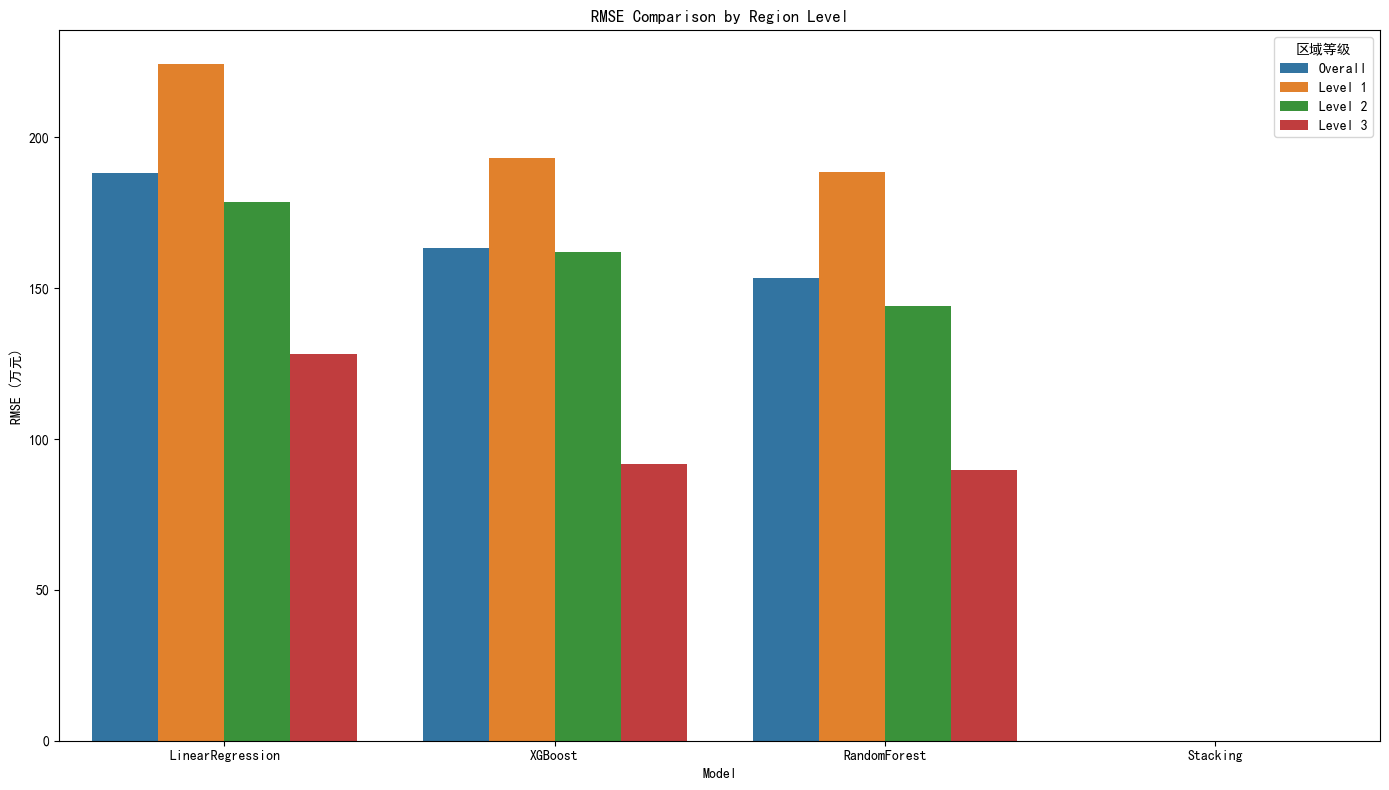

C:\Users\28294\AppData\Local\Temp\ipykernel_9952\2337181735.py:69: UserWarning: Glyph 178 (\N{SUPERSCRIPT TWO}) missing from font(s) SimHei.
  plt.tight_layout()
C:\Users\28294\AppData\Local\Temp\ipykernel_9952\2337181735.py:70: UserWarning: Glyph 178 (\N{SUPERSCRIPT TWO}) missing from font(s) SimHei.
  plt.savefig('r2_comparison.png', dpi=300)
E:\Develop\Anaconda\Anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 178 (\N{SUPERSCRIPT TWO}) missing from font(s) SimHei.
  fig.canvas.print_figure(bytes_io, **kw)


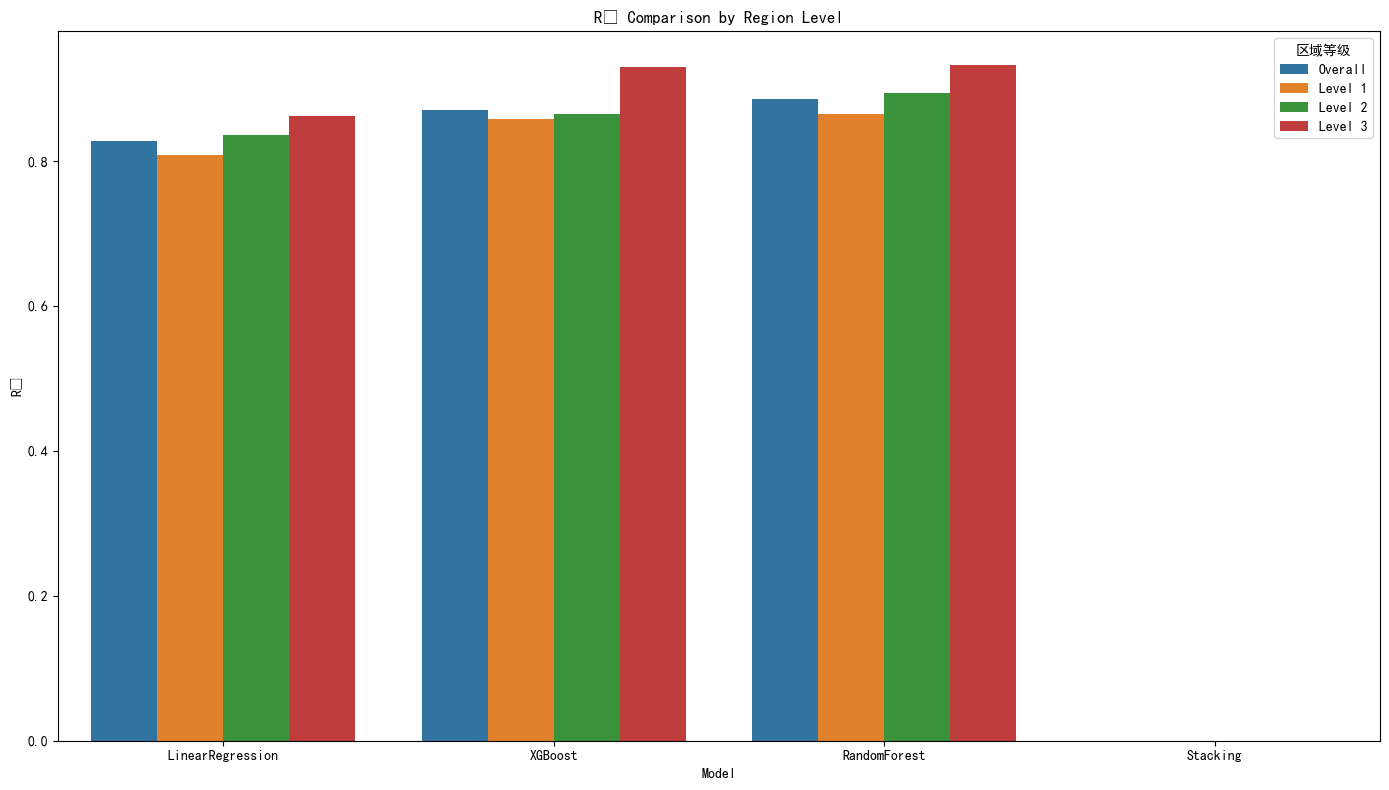

888


In [15]:
# 8. 结果可视化
def plot_results(results):
    """可视化模型结果"""

    # 设置中文字体
    try:
        # 尝试使用系统中可用的中文字体
        plt.rcParams["font.family"] = ["SimHei"]
        # 确保符号显示正常
        plt.rcParams["axes.unicode_minus"] = False
    except:
        print("警告: 中文字体设置失败，图形中的中文可能无法正确显示。")
        
    # 创建结果数据框
    rmse_data = []
    r2_data = []
    
    for model_name, res in results.items():
        # 添加总体结果
        rmse_data.append({
            'Model': model_name,
            'Region Level': 'Overall',
            'RMSE': res['overall_RMSE']
        })
        r2_data.append({
            'Model': model_name,
            'Region Level': 'Overall',
            'R2': res['overall_R2']
        })
        
        # 添加各区域结果
        for level, metrics in res['level_results'].items():
            level_name = f"Level {level}"
            rmse_data.append({
                'Model': model_name,
                'Region Level': level_name,
                'RMSE': metrics['RMSE']
            })
            r2_data.append({
                'Model': model_name,
                'Region Level': level_name,
                'R2': metrics['R2']
            })
    
    rmse_df = pd.DataFrame(rmse_data)
    r2_df = pd.DataFrame(r2_data)
    
    # 区域等级排序
    level_order = ['Overall'] + [f'Level {i}' for i in sorted(df['区域等级'].unique())]
    rmse_df['Region Level'] = pd.Categorical(rmse_df['Region Level'], categories=level_order, ordered=True)
    r2_df['Region Level'] = pd.Categorical(r2_df['Region Level'], categories=level_order, ordered=True)
    
    # 绘制RMSE比较
    plt.figure(figsize=(14, 8))
    sns.barplot(x='Model', y='RMSE', hue='Region Level', data=rmse_df.sort_values('Region Level'))
    plt.title('RMSE Comparison by Region Level')
    plt.ylabel('RMSE (万元)')
    plt.legend(title='区域等级')
    plt.tight_layout()
    plt.savefig('rmse_comparison.png', dpi=300)
    plt.show()
    
    # 绘制R²比较
    plt.figure(figsize=(14, 8))
    sns.barplot(x='Model', y='R2', hue='Region Level', data=r2_df.sort_values('Region Level'))
    plt.title('R² Comparison by Region Level')
    plt.ylabel('R²')
    plt.legend(title='区域等级')
    plt.tight_layout()
    plt.savefig('r2_comparison.png', dpi=300)
    plt.show()

# 调用可视化
plot_results(results)

In [17]:
import warnings
import time
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# 9. SHAP特征分析
def analyze_shap(models, X, y, region_level):
    """进行SHAP特征分析"""
    logging.info(f"\n=== 开始分析区域等级 {region_level} ===")
    
    # 1. 数据准备
    try:
        # 筛选指定区域等级的数据
        level_data = X[X['区域等级'] == region_level].copy()
        y_region = y.loc[level_data.index]
        
        # 检查数据有效性
        if len(level_data) == 0:
            logging.warning(f"区域等级 {region_level} 无数据")
            return None
            
        logging.info(f"有效样本数: {len(level_data)}")
        
        # 处理NaN值
        numeric_cols = level_data.select_dtypes(include=[np.number]).columns
        level_data[numeric_cols] = level_data[numeric_cols].fillna(level_data[numeric_cols].median())
        
        # 彻底清理特征名称，确保唯一性
        feature_names = []
        seen = {}
        for col in level_data.columns:
            clean_col = re.sub(r'[^a-zA-Z0-9_]', '_', str(col).encode('ascii', 'ignore').decode('ascii').strip())
            if clean_col in seen:
                seen[clean_col] += 1
                clean_col = f"{clean_col}_{seen[clean_col]}"
            else:
                seen[clean_col] = 0
            feature_names.append(clean_col)
        level_data.columns = feature_names
        
        # 确保数据类型为float32，减少内存使用
        level_data = level_data.astype(np.float32)
        
        # 采样数据以加速SHAP计算
        max_samples = 300  # Reduced for faster computation
        if len(level_data) > max_samples:
            level_data, _, y_region, _ = train_test_split(
                level_data, y_region, train_size=max_samples, random_state=42
            )
            logging.info(f"采样后样本数: {len(level_data)}")
        
        # Convert to numpy array for SHAP
        level_data_np = level_data.to_numpy()
        
    except Exception as e:
        logging.error(f"数据准备失败: {str(e)}")
        return None
    
    # 2. 特征分析
    shap_values = {}
    
    for name, res in models.items():
        model = res['model']
        logging.info(f"\n分析模型: {name}")
        
        try:
            # 确保模型已训练
            if not hasattr(model, 'predict'):
                logging.info("训练模型...")
                try:
                    model.fit(level_data, y_region)
                except Exception as e:
                    logging.error(f"模型 {name} 训练失败: {str(e)}")
                    shap_values[name] = pd.Series()
                    continue
            
            # 特征重要性分析
            if name == 'LinearRegression':
                coef = pd.Series(model.coef_, index=level_data.columns)
                shap_values[name] = coef.abs().sort_values(ascending=False)
                logging.info("使用线性回归系数作为特征重要性")
                
            elif name in ['XGBoost', 'RandomForest']:
                logging.info("尝试SHAP分析...")
                try:
                    start_time = time.time()
                    explainer = shap.TreeExplainer(
                        model,
                        feature_perturbation='tree_path_dependent',
                        approximate=True
                    )
                    shap_vals = explainer.shap_values(level_data_np, check_additivity=False)
                    
                    if isinstance(shap_vals, list):
                        shap_vals = np.array(shap_vals)
                    
                    mean_abs_shap = pd.Series(
                        np.abs(shap_vals).mean(axis=0),
                        index=level_data.columns
                    )
                    shap_values[name] = mean_abs_shap.sort_values(ascending=False)
                    logging.info(f"SHAP分析成功，耗时: {time.time() - start_time:.2f}秒")
                    
                except Exception as e:
                    logging.error(f"SHAP失败: {str(e)}")
                    if hasattr(model, 'feature_importances_'):
                        importance = pd.Series(
                            model.feature_importances_,
                            index=level_data.columns
                        )
                        shap_values[name] = importance.sort_values(ascending=False)
                        logging.info("使用内置特征重要性")
                    else:
                        logging.warning("无法获取特征重要性")
                        shap_values[name] = pd.Series()
            
            elif name == 'Stacking':
                logging.info("分析Stacking模型...")
                try:
                    result = permutation_importance(
                        model, level_data, y_region,
                        n_repeats=5, random_state=42, n_jobs=-1
                    )
                    perm_importance = pd.Series(
                        result.importances_mean,
                        index=level_data.columns
                    )
                    shap_values[name] = perm_importance.sort_values(ascending=False)
                    logging.info("排列重要性分析成功")
                except Exception as e:
                    logging.error(f"排列重要性失败: {str(e)}")
                    shap_values[name] = pd.Series()
            
        except Exception as e:
            logging.error(f"模型 {name} 分析失败: {str(e)}")
            shap_values[name] = pd.Series()
    
    # 3. 结果处理
    if not any(not v.empty for v in shap_values.values()):
        logging.error("所有模型分析均失败")
        return None
    
    # 4. 可视化
    try:
        plot_data = pd.DataFrame()
        for name, values in shap_values.items():
            if not values.empty:
                norm_values = values / values.sum()
                plot_data[name] = norm_values
        
        if not plot_data.empty:
            plot_data = plot_data.iloc[:10]
            plot_data.index = [f"{idx}_{i}" if plot_data.index.duplicated()[i] else idx 
                              for i, idx in enumerate(plot_data.index)]
            
            plt.figure(figsize=(12, 8))
            sns.heatmap(
                plot_data.T,
                annot=True,
                fmt=".2f",
                cmap="coolwarm",
                cbar_kws={'label': '归一化特征重要性'}
            )
            plt.title(f"区域等级 {region_level} 特征重要性")
            plt.tight_layout()
            
            os.makedirs("results/shap", exist_ok=True)
            plt.savefig(f"results/shap/level_{region_level}.png", dpi=300)
            plt.close()
            
            plot_data.to_csv(f"results/shap/level_{region_level}.csv")
            logging.info(f"特征重要性可视化保存: results/shap/level_{region_level}.png")
            
    except Exception as e:
        logging.error(f"可视化失败: {str(e)}")
    
    return shap_values

# Initialize report (to fix NameError)
report = ""  # Initialize as empty string; append model evaluation results if needed

# Debug Stacking model initialization
logging.info("检查模型状态:")
for name, res in results.items():
    logging.info(f"模型 {name}: {'有效' if hasattr(res['model'], 'predict') else '无效'}")

# Reinitialize Stacking model if necessary
if not hasattr(results.get('Stacking', {}).get('model', {}), 'predict'):
    logging.info("重新初始化Stacking模型...")
    xgb = XGBRegressor(max_depth=5, learning_rate=0.1, n_estimators=200, random_state=42)
    rf = RandomForestRegressor(n_estimators=50, max_features='sqrt', random_state=42)  # Reduced estimators
    stack = StackingCVRegressor(
        regressors=[(xgb, 'xgb'), (rf, 'rf')],
        meta_regressor=LinearRegression(),
        cv=5,
        use_features_in_secondary=True
    )
    results['Stacking'] = {'model': stack}  # Update results dictionary
    logging.info("Stacking模型重新初始化完成")

# 分析中心城区和远郊区
logging.info("\n分析中心城区特征重要性...")
shap_center = analyze_shap(results, X, y, region_level=3)  # 中心城区

logging.info("\n分析远郊区特征重要性...")
shap_outer = analyze_shap(results, X, y, region_level=1)  # 远郊区

# 添加SHAP结果到最终报告
shap_report = "\n## SHAP特征重要性分析\n"

if shap_center is not None:
    shap_report += "### 中心城区 (Level 3)\n"
    for model, values in shap_center.items():
        if not values.empty:
            shap_report += f"- **{model}** 前5特征:\n"
            for feature, importance in values.head(5).items():
                shap_report += f"  - {feature}: {importance:.4f}\n"
        else:
            shap_report += f"- **{model}**: 无有效特征重要性数据\n"

if shap_outer is not None:
    shap_report += "\n### 远郊区 (Level 1)\n"
    for model, values in shap_outer.items():
        if not values.empty:
            shap_report += f"- **{model}** 前5特征:\n"
            for feature, importance in values.head(5).items():
                shap_report += f"  - {feature}: {importance:.4f}\n"
        else:
            shap_report += f"- **{model}**: 无有效特征重要性数据\n"

# Append SHAP report to existing report
report += shap_report

# Save updated report
with open('results/model_evaluation_report.md', 'w', encoding='utf-8') as f:
    f.write(report)
logging.info("SHAP分析报告已保存至 results/model_evaluation_report.md")

2025-06-02 21:39:19,030 - INFO - 检查模型状态:
2025-06-02 21:39:19,032 - INFO - 模型 LinearRegression: 有效
2025-06-02 21:39:19,032 - INFO - 模型 XGBoost: 有效
2025-06-02 21:39:19,032 - INFO - 模型 RandomForest: 有效
2025-06-02 21:39:19,032 - INFO - 模型 Stacking: 无效
2025-06-02 21:39:19,033 - INFO - 重新初始化Stacking模型...
2025-06-02 21:39:19,033 - INFO - Stacking模型重新初始化完成
2025-06-02 21:39:19,035 - INFO - 
分析中心城区特征重要性...
2025-06-02 21:39:19,035 - INFO - 
=== 开始分析区域等级 3 ===
2025-06-02 21:39:19,039 - INFO - 有效样本数: 5990
2025-06-02 21:39:19,046 - INFO - 采样后样本数: 300
2025-06-02 21:39:19,046 - INFO - 
分析模型: LinearRegression
2025-06-02 21:39:19,050 - INFO - 使用线性回归系数作为特征重要性
2025-06-02 21:39:19,050 - INFO - 
分析模型: XGBoost
2025-06-02 21:39:19,052 - INFO - 尝试SHAP分析...
2025-06-02 21:39:19,317 - INFO - SHAP分析成功，耗时: 0.27秒
2025-06-02 21:39:19,318 - INFO - 
分析模型: RandomForest
2025-06-02 21:39:19,319 - INFO - 尝试SHAP分析...
2025-06-02 21:56:50,100 - INFO - SHAP分析成功，耗时: 1050.78秒
2025-06-02 21:56:50,100 - INFO - 
分析模型: Stacking
2025

999


In [23]:
import joblib
from datetime import datetime

# Ensure logging is set up (already done before Step 9)
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Debug: Inspect results dictionary
logging.info("检查 results 字典内容:")
for name, res in results.items():
    logging.info(f"模型 {name}: {res.keys()}")
    logging.info(f"  - model: {'有效' if hasattr(res.get('model', None), 'predict') else '无效'}")
    logging.info(f"  - overall_RMSE: {res.get('overall_RMSE', '缺失')}")
    logging.info(f"  - overall_R2: {res.get('overall_R2', '缺失')}")
    logging.info(f"  - level_results: {res.get('level_results', '缺失')}")

# 10. 保存最终模型和结果
# 创建结果目录
os.makedirs('results', exist_ok=True)
logging.info("结果目录已创建: results")

# 保存最佳模型
best_model_name = None
try:
    # Find best model only among valid models with overall_RMSE
    valid_models = {k: v for k, v in results.items() if 'overall_RMSE' in v and not pd.isna(v['overall_RMSE'])}
    if valid_models:
        best_model_name = min(valid_models, key=lambda k: valid_models[k]['overall_RMSE'])
        best_model = results[best_model_name]['model']
        if best_model is not None and hasattr(best_model, 'predict'):
            joblib.dump(best_model, f'results/best_model_{best_model_name}.pkl')
            logging.info(f"保存最佳模型: {best_model_name}")
        else:
            logging.warning(f"最佳模型 {best_model_name} 无效，无法保存")
    else:
        logging.warning("无有效模型可供选择（缺少 overall_RMSE）")
except Exception as e:
    logging.error(f"保存最佳模型失败: {str(e)}")

# 保存所有模型
for name, res in results.items():
    try:
        model = res.get('model', None)
        if model is not None and hasattr(model, 'predict'):
            joblib.dump(model, f'results/{name}_model.pkl')
            logging.info(f"保存模型: {name}")
        else:
            logging.warning(f"模型 {name} 无效，跳过保存")
    except Exception as e:
        logging.error(f"保存模型 {name} 失败: {str(e)}")

# 保存结果数据
results_list = []
for name, res in results.items():
    if res.get('model', None) is None or not hasattr(res.get('model'), 'predict'):
        logging.warning(f"模型 {name} 无效，跳过结果记录")
        continue
    if 'overall_RMSE' not in res or 'overall_R2' not in res or 'level_results' not in res:
        logging.warning(f"模型 {name} 缺少必要键（overall_RMSE, overall_R2, level_results），跳过结果记录")
        continue
    row = {
        'Model': name,
        'Overall_RMSE': res['overall_RMSE'],
        'Overall_R2': res['overall_R2']
    }
    # 添加各区域结果
    for level, metrics in res['level_results'].items():
        row[f'Level_{level}_RMSE'] = metrics.get('RMSE', np.nan)
        row[f'Level_{level}_R2'] = metrics.get('R2', np.nan)
    results_list.append(row)

try:
    if results_list:
        results_df = pd.DataFrame(results_list)
        results_df.to_csv('results/model_performance_results.csv', index=False)
        logging.info("模型性能结果已保存至: results/model_performance_results.csv")
    else:
        logging.warning("无有效结果数据可保存")
except Exception as e:
    logging.error(f"保存模型性能结果失败: {str(e)}")

# 生成报告
report = f"""# 房价预测模型评估报告
**生成时间**: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}
**数据量**: {len(df)} 条记录
**区域分布**: 
{df['区域等级'].value_counts().to_string()}

## 最佳模型: {best_model_name if best_model_name else '无有效模型'}
- **总体RMSE**: {(results[best_model_name]['overall_RMSE'] if best_model_name and 'overall_RMSE' in results[best_model_name] else 'N/A')}
- **总体R²**: {(results[best_model_name]['overall_R2'] if best_model_name and 'overall_R2' in results[best_model_name] else 'N/A')}

## 详细结果:
{(pd.DataFrame(results_list).to_markdown(index=False) if results_list else '无有效结果数据')}
"""

# 追加SHAP分析结果（从Step 9）
shap_report = "\n## SHAP特征重要性分析\n"
if 'shap_center' in globals() and shap_center is not None:
    shap_report += "### 中心城区 (Level 3)\n"
    for model, values in shap_center.items():
        if not values.empty:
            shap_report += f"- **{model}** 前5特征:\n"
            for feature, importance in values.head(5).items():
                shap_report += f"  - {feature}: {importance:.4f}\n"
        else:
            shap_report += f"- **{model}**: 无有效特征重要性数据\n"

if 'shap_outer' in globals() and shap_outer is not None:
    shap_report += "\n### 远郊区 (Level 1)\n"
    for model, values in shap_outer.items():
        if not values.empty:
            shap_report += f"- **{model}** 前5特征:\n"
            for feature, importance in values.head(5).items():
                shap_report += f"  - {feature}: {importance:.4f}\n"
        else:
            shap_report += f"- **{model}**: 无有效特征重要性数据\n"

# 合并报告
report += shap_report

# 保存报告
try:
    with open('results/model_evaluation_report.md', 'w', encoding='utf-8') as f:
        f.write(report)
    logging.info("分析报告已保存至: results/model_evaluation_report.md")
except Exception as e:
    logging.error(f"保存分析报告失败: {str(e)}")

logging.info("分析完成! 结果保存在 'results' 目录")

2025-06-02 23:16:13,957 - INFO - 检查 results 字典内容:
2025-06-02 23:16:13,957 - INFO - 模型 LinearRegression: dict_keys(['model', 'name', 'overall_RMSE', 'overall_R2', 'level_results'])
2025-06-02 23:16:13,957 - INFO -   - model: 有效
2025-06-02 23:16:13,959 - INFO -   - overall_RMSE: 188.12168649025966
2025-06-02 23:16:13,959 - INFO -   - overall_R2: 0.8279253045905819
2025-06-02 23:16:13,960 - INFO -   - level_results: {1: {'RMSE': 224.1851435136074, 'R2': 0.8075897585404069}, 2: {'RMSE': 178.49193826343026, 'R2': 0.836191662042352}, 3: {'RMSE': 128.27540943517158, 'R2': 0.8616352889241007}}
2025-06-02 23:16:13,961 - INFO - 模型 XGBoost: dict_keys(['model', 'name', 'overall_RMSE', 'overall_R2', 'level_results'])
2025-06-02 23:16:13,961 - INFO -   - model: 有效
2025-06-02 23:16:13,961 - INFO -   - overall_RMSE: 163.3077238497372
2025-06-02 23:16:13,961 - INFO -   - overall_R2: 0.8703260518284953
2025-06-02 23:16:13,961 - INFO -   - level_results: {1: {'RMSE': 192.9807974477635, 'R2': 0.8574252167